# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

Regarding the data, we are not going to have a __csv file__, that would be too easy :) instead we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). When you download them you will notice that their format is text files, so you will have to work a little there to be able to use and process them. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [1]:
import os

In [2]:
def walkir(folder):
    for dirpath, _, files in os.walk(folder):
            for filename in files:
                yield (dirpath, filename)

In [3]:
X_train = []
y_train = []

for name in walkir("../src/movie_reviews_dataset/train/pos"):
    with open(os.path.join(*name), "r") as f:
        data = f.read()
    X_train.append(data)
    y_train.append(1)

for name in walkir("../src/movie_reviews_dataset/train/neg"):
    with open(os.path.join(*name), "r") as f:
        data = f.read()
    X_train.append(data)
    y_train.append(0)

In [4]:
X_test = []
y_test = []

for name in walkir("../src/movie_reviews_dataset/test/pos"):
    with open(os.path.join(*name), "r") as f:
        data = f.read()
    X_test.append(data)
    y_test.append(1)

for name in walkir("../src/movie_reviews_dataset/test/neg"):
    with open(os.path.join(*name), "r") as f:
        data = f.read()
    X_test.append(data)
    y_test.append(0)

### *Don't change anything in this block, just make it run correctly*

We are going to check that you have done it right and for that we are going to see if the dimensions match.

In [5]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

#### Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (`at this point we leave it to your free choice, for example: you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice`), this function simply groups the previous ones for a more simplified use.

In [6]:
import text_normalizer

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re
import nltk
import spacy
import unicodedata

from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer

nltk.download('stopwords')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### *Don't change anything in this block, just make it run correctly*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

Note that the functions are not defined in the notebook itself, but rather that they are in a python file and you must import them in order to use them. Same thing with names, you're going to have to name your functions the way they were named.

In [8]:
import nltk

# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away .
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


In [9]:
X_train_norm = text_normalizer.normalize_corpus(X_train,
    html_stripping=True,
    contraction_expansion=True,
    accented_char_removal=True,
    text_lower_case=True,
    text_stemming=True,
    text_lemmatization=False,
    special_char_removal=True,
    remove_digits=True,
    stopword_removal=True,
    stopwords=stopword_list
)

In [10]:
X_test_norm = text_normalizer.normalize_corpus(X_test,
    html_stripping=True,
    contraction_expansion=True,
    accented_char_removal=True,
    text_lower_case=True,
    text_stemming=True,
    text_lemmatization=False,
    special_char_removal=True,
    remove_digits=True,
    stopword_removal=True,
    stopwords=stopword_list
)

---
## 3. Feature Engineering

You already have the pre-processed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.

In [11]:
# We will use TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

max_features=1000
tf_idf_vec = TfidfVectorizer(max_features=max_features)

In [12]:
X_train_tf_idf = tf_idf_vec.fit_transform(X_train_norm)
X_test_tf_idf = tf_idf_vec.transform(X_test_norm)
all_words = tf_idf_vec.get_feature_names()
len(all_words)

/home/app/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1000

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

In addition to training the model we ask you to show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`

To do this you must complete the `get_performance` function of the `evaluation.py` script.

Also, you must complete the `plot_roc` function so that it can show:

* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [13]:
# Training a LOGISTIC REGRESSION classifier model - with RandomizedSearchCV to find the best combination of hyperparameters

hyperparameter_grid_LogReg = {
    "tol": [0.00001, 0.0001, 0.001],
    "C": [2, 1, 0.5],
    "max_iter": [1000, 500, 100]
}

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

model_LogReg_srCV = LogisticRegression(n_jobs=-1, random_state=42)
rand_srCV_LogReg = RandomizedSearchCV(model_LogReg_srCV, hyperparameter_grid_LogReg, scoring="roc_auc", random_state=42)
rand_srCV_LogReg.fit(X_train_tf_idf, y_train)

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=42),
                   param_distributions={'C': [2, 1, 0.5],
                                        'max_iter': [1000, 500, 100],
                                        'tol': [1e-05, 0.0001, 0.001]},
                   random_state=42, scoring='roc_auc')

In [15]:
rand_srCV_LogReg.best_params_

{'tol': 0.0001, 'max_iter': 500, 'C': 1}

In [16]:
rand_srCV_LogReg.best_estimator_.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [17]:
import pandas as pd
pd.DataFrame(rand_srCV_LogReg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_max_iter,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.329654,5.070795,0.024479,0.018843,0.001,100,2,"{'tol': 0.001, 'max_iter': 100, 'C': 2}",0.930946,0.923618,0.916704,0.924780,0.928666,0.924943,0.004890,9
1,3.659245,1.481168,0.010211,0.001533,0.0001,500,1,"{'tol': 0.0001, 'max_iter': 500, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
2,3.290897,0.620117,0.017610,0.005571,0.00001,1000,1,"{'tol': 1e-05, 'max_iter': 1000, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
3,1.896921,0.700983,0.017760,0.008425,0.00001,500,0.5,"{'tol': 1e-05, 'max_iter': 500, 'C': 0.5}",0.929849,0.924512,0.917500,0.924416,0.928484,0.924952,0.004301,7
4,0.983166,0.090894,0.014952,0.004183,0.00001,1000,2,"{'tol': 1e-05, 'max_iter': 1000, 'C': 2}",0.930946,0.923618,0.916704,0.924780,0.928666,0.924943,0.004890,9
5,0.916942,0.064328,0.009861,0.003961,0.001,1000,1,"{'tol': 0.001, 'max_iter': 1000, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
6,0.934410,0.071030,0.009380,0.005395,0.0001,100,1,"{'tol': 0.0001, 'max_iter': 100, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
7,0.902001,0.045923,0.007316,0.001179,0.001,100,1,"{'tol': 0.001, 'max_iter': 100, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
8,0.998765,0.228800,0.006995,0.002857,0.00001,500,1,"{'tol': 1e-05, 'max_iter': 500, 'C': 1}",0.930883,0.924390,0.917534,0.925139,0.929059,0.925401,0.004613,1
9,0.921167,0.047501,0.005482,0.001192,0.00001,100,0.5,"{'tol': 1e-05, 'max_iter': 100, 'C': 0.5}",0.929849,0.924512,0.917500,0.924416,0.928484,0.924952,0.004301,7


In [18]:
y_pred_LogReg_srCV = rand_srCV_LogReg.predict(X_test_tf_idf)

In [20]:
import evaluation

In [21]:
evaluation.get_performance(y_pred_LogReg_srCV, y_test, labels=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.85932
Precision: 0.8514200766763164
Recall: 0.87056
F1 Score: 0.8608836675764407

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10601   1899
1   1618  10882


(0.85932, 0.8514200766763164, 0.87056, 0.8608836675764407)

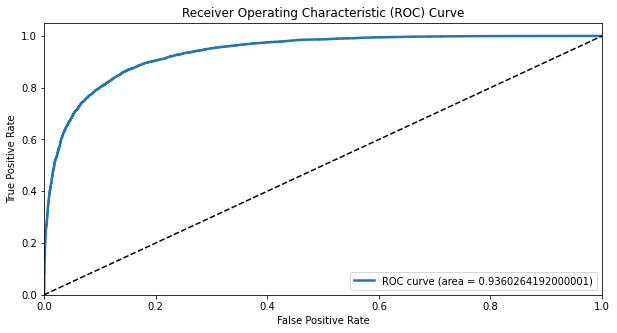

In [22]:
roc_auc = evaluation.plot_roc(rand_srCV_LogReg, y_test, X_test_tf_idf)

In [23]:
print("The ROC-AUC value is",roc_auc)

The ROC-AUC value is 0.9360264192000001


### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [24]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if your model at least exceeds an ROC-AUC of 0.93

In [101]:
def check_roc(roc_auc):
    if roc_auc > 0.9:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [48]:
from gensim.models import Word2Vec

In [49]:
X_train_toktok = [tokenizer.tokenize(review) for review in X_train_norm]
X_test_toktok = [tokenizer.tokenize(review) for review in X_test_norm]

In [50]:
model_w2v = Word2Vec(sentences=X_train_toktok, vector_size=100)  # Replace with your trained model

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [51]:
import numpy as np

In [52]:
def vectorizer(corpus, model, num_features=100):
    # Put your code
    vocabulary = set(model.wv.index_to_key)
    
    corpus_vectors = []
    for review in corpus:
        
        review_w2v = []
        for word in review:
            if word in vocabulary:
                word_vector = model.wv[word]
            else:
                word_vector = np.zeros((num_features), dtype="float32")
            review_w2v.append(word_vector)
        
        avg_vector = np.add.reduce(review_w2v)/len(review_w2v)
        corpus_vectors.append(avg_vector)
                
    return corpus_vectors

In [53]:
X_train_w2vect = vectorizer(X_train_toktok, model_w2v)
X_test_w2vect = vectorizer(X_test_toktok, model_w2v)

### *Don't change anything in this block, just make it run correctly*

Let's do a simple check of the embedding that you just trained.

In [54]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.7077704668045044


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [55]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [91]:
# Training a SVC classifier model - with RandomizedSearchCV to find the best combination of hyperparameters

hyperparameter_grid_SVC_w2v = {
    "tol": [0.0001, 0.001, 0.01],
    "C": [2, 1, 0.5],
    "gamma": ["scale", "auto"]
}

In [92]:
from sklearn.svm import SVC

model_SVC_srCV_w2v = SVC(random_state=42, probability=True)
rand_srCV_SVC_w2v = RandomizedSearchCV(model_SVC_srCV_w2v, hyperparameter_grid_SVC_w2v, scoring="roc_auc", random_state=42)
rand_srCV_SVC_w2v.fit(X_train_w2vect, y_train)

RandomizedSearchCV(estimator=SVC(probability=True, random_state=42),
                   param_distributions={'C': [2, 1, 0.5],
                                        'gamma': ['scale', 'auto'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='roc_auc')

In [93]:
rand_srCV_SVC_w2v.best_params_

{'tol': 0.01, 'gamma': 'scale', 'C': 2}

In [94]:
rand_srCV_SVC_w2v.best_estimator_.get_params()

{'C': 2,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.01,
 'verbose': False}

In [95]:
pd.DataFrame(rand_srCV_SVC_w2v.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,187.127349,5.820293,5.080631,0.294972,0.0001,scale,2,"{'tol': 0.0001, 'gamma': 'scale', 'C': 2}",0.901469,0.903362,0.892694,0.894089,0.905645,0.899452,0.005141,3
1,184.689316,4.036135,5.212856,0.633573,0.001,scale,2,"{'tol': 0.001, 'gamma': 'scale', 'C': 2}",0.901470,0.903367,0.892692,0.894090,0.905644,0.899453,0.005142,2
2,189.958650,6.048251,5.280689,0.143211,0.01,scale,1,"{'tol': 0.01, 'gamma': 'scale', 'C': 1}",0.899550,0.902336,0.890569,0.891776,0.903674,0.897581,0.005413,4
3,208.469764,2.135654,5.739395,0.059123,0.01,auto,2,"{'tol': 0.01, 'gamma': 'auto', 'C': 2}",0.890492,0.893132,0.879656,0.879948,0.893331,0.887312,0.006214,6
4,219.213271,16.095513,6.104573,0.480652,0.0001,auto,2,"{'tol': 0.0001, 'gamma': 'auto', 'C': 2}",0.890501,0.893149,0.879654,0.879955,0.893289,0.887310,0.006209,7
5,196.632192,1.944285,5.330263,0.030516,0.001,scale,0.5,"{'tol': 0.001, 'gamma': 'scale', 'C': 0.5}",0.896901,0.900616,0.887923,0.888642,0.901273,0.895071,0.005745,5
6,240.547952,3.463187,7.539587,1.023779,0.001,auto,0.5,"{'tol': 0.001, 'gamma': 'auto', 'C': 0.5}",0.881839,0.885380,0.873016,0.869954,0.883916,0.878821,0.006171,10
7,243.805588,5.785131,7.295217,0.891744,0.0001,auto,0.5,"{'tol': 0.0001, 'gamma': 'auto', 'C': 0.5}",0.881842,0.885384,0.873014,0.869954,0.883915,0.878822,0.006172,9
8,277.484697,39.128153,8.457069,1.582579,0.01,auto,1,"{'tol': 0.01, 'gamma': 'auto', 'C': 1}",0.886762,0.889927,0.877165,0.875806,0.889324,0.883797,0.006079,8
9,187.415516,4.880842,5.249678,0.612150,0.01,scale,2,"{'tol': 0.01, 'gamma': 'scale', 'C': 2}",0.901484,0.903380,0.892680,0.894108,0.905633,0.899457,0.005142,1


In [96]:
y_pred_SVC_srCV_w2v = rand_srCV_SVC_w2v.predict(X_test_w2vect)

In [97]:
evaluation.get_performance(y_pred_SVC_srCV_w2v, y_test, labels=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.82604
Precision: 0.8279552587108715
Recall: 0.82312
F1 Score: 0.8255305492036747

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     12500
           1       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10362   2138
1   2211  10289


(0.82604, 0.8279552587108715, 0.82312, 0.8255305492036747)

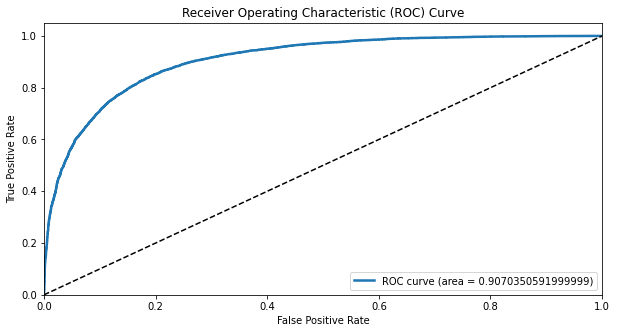

In [98]:
roc_auc = evaluation.plot_roc(rand_srCV_SVC_w2v, y_test, X_test_w2vect)

In [99]:
print("The ROC-AUC value is",roc_auc)

The ROC-AUC value is 0.9070350591999999


### *Don't change anything in this block, just make it run correctly*

In [102]:
check_roc(roc_auc)

Success!


---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.